# 추천 시스템의 기초

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

추천 시스템(recommender system)이란 사용자(user)가 상품(item)에 대해 어떻게 평가하는지를 예측하는 예측 시스템의 일종이다.

Amazon과 같은 인터넷 쇼핑 사이트나 Netflix 등의 온라인 비디오 콘텐츠 제공 사이트는 사용자가 각각의 상품에 대해 평가한 평점(rate)을 가지고 있다. 이 기록을 기반으로 해서 사용자가 아직 평가하지 않은 상품에 대한 점수를 예측함으로써 그 사용자에게 어떤 상품을 추천할 지 결정할 수 있다.

## Surprise 패키지

여기에서는 파이썬의 Surprise패키지를 사용하여 추천 시스템을 구현해 본다. Surprise 패키지는 Nicolas Hug 가 만든 오픈 소스 추천 시스템 패키지로 문서화가 잘 되어 있다, 
* https://github.com/NicolasHug/Surprise
* http://surprise.readthedocs.io/en/latest/index.html

Surprise 패키지는 다음 논문들을 기반으로 하여 작성되었으며 세부적인 파라미터 설정 및 수식은 논문 내용을 참고한다.
* `Koren2010`: "Factor in the Neighbors: Scalable and Accurate Collaborative Filtering",  YEHUDA KOREN. 2010
  * http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf
* `Koren2011`: "Collaborative Filtering on Ordinal User Feedback", Yehuda Koren and Joseph Sill, 2011
  * http://www.ijcai.org/Proceedings/13/Papers/449.pdf

Surprise 패키지는 콘솔에서 `pip install surprise` 명령으로 설치하거나 다음과 같이 github에서 repository를 clone하여 직접 설치한다. (SVD 모형은 최신 버전의 master branch에만 있으므로 git clone해야 사용할 수 있다.)


```
$ git clone https://github.com/NicolasHug/Surprise.git
$ cd Surprise
$ python setup.py install
```

실습을 위해 다음과 같이 Surprise 패키지를 임포트한다.

In [1]:
import surprise

## 평점 데이터

surprise 패키지에서는 MovieLense라는 영화 추천 웹사이트의 데이터를 샘플 평점 데이터로 제공한다. MovieLense 데이터 중 10만개의 샘플 데이터세트는 다음과 같이 로드한다.

In [2]:
data = surprise.Dataset.load_builtin('ml-100k')

이 데이터는 다음과 같이 데이터프레임으로 변환할 수 있다.

In [3]:
df = pd.DataFrame(data.raw_ratings, columns=["user", "item", "rate", "id"])
del df["id"]
df.head(10)

,user,item,rate
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0
5,298,474,4.0
6,115,265,2.0
7,253,465,5.0
8,305,451,3.0
9,6,86,3.0


여기에서 user 열은 사용자 아이디, item 열은 상품 아이디, rate 열은 평점이다. 즉, 196번 사용자는 242번 영화에 대해 평점 3점을 주었음을 알 수 있다.

이 데이터프레임에서 볼 수 있듯이 

> **추천 시스템은 사용자 아이디와 상품 아이디라는 두 개의 카테고리 입력과 평점 출력을 가지는 예측 시스템**

이다.

이 데이터를 다음과 같이 피봇테이블(pivot table) 형태로 만들면 x축이 상품, y축이 사용자 아이디인 평점 행렬(rate matrix) $R$ 이 된다.

평점 행렬 $R$의 행은 특정 사용자의 평점이고 평점 행렬 $R$의 열은 특정 상품의 평점이다.

In [4]:
df_table = df.set_index(["user", "item"]).unstack()

이 평점 행렬의 일부만 살펴보면 다음과 같이 평점 데이터가 일부 위치에만 존재하는 sparse 행렬임을 알 수 있다.

In [5]:
df_table.fillna("").ix[212:222, 808:817]

rate                                
item  211 212 213 214 215 216 217 218 219
user                                     
290     3                   4       2    
291         4       4   4           4   4
292                 3                    
293     4       3       4   4   3   2    
294                                      
295             5       5   5   4   5    
296     4                                
297     4       3       2   4       3    
298     5       3       5                
299     4   4   5           5

평점 행렬의 빈칸을 흰색, 점수를 검은색으로 시각화 하면 다음과 같다.

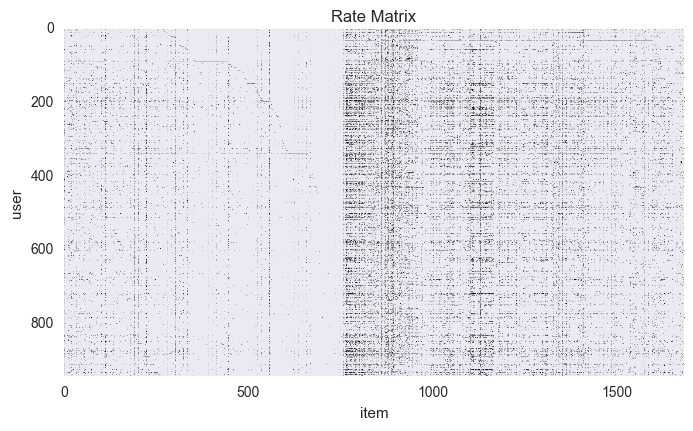

In [6]:
plt.imshow(df_table)
plt.grid(False)
plt.xlabel("item")
plt.ylabel("user")
plt.title("Rate Matrix")
plt.show()

## 추천 시스템 알고리즘

추천 시스템은 두 개의 카테고리 값 입력에서 하나의 실수 값 출력을 예측하는 회귀 모형이지만 여러가지 방법으로 예측 성능을 향상시키고 있다. 추천 시스템에서 사용되는 알고리즘은 다음과 같다.

1. 베이스라인 모형
2. Collaborative Filtering
  * 2-1. Neighborhood Models
    * User-based CF
    * Item-based CF
  * 2-2. Latent Factor Models 
    * Matrix Factorization
    * SVD 
3. Content-Based Recommendation

## 베이스라인 모형

베이스라인 모형(baseline model)은 사용자 아이디 $u$, 상품 아이디 $i$, 두 개의 카테고리 값 입력에서 평점 $r_{ui}$의 예측치 $\hat{r}_{ui}$  을 예측하는 가장 단순한 모형으로 다음과 같이 사용자와 상품 특성에 의한 평균 평점의 합으로 나타난다.

$$ \hat{r}_{ui} = \mu + b_u + b_i $$

이 식에서 $\mu$는 전체 평점의 평균이고, $b_u$는 동일한 사용자에 의한 평점 조정값,  $b_i$는 동일한 상품에 대한 평점 조정값이다.

베이스라인 모형은 오차 함수를 최소화하도록 구해진다.

$$ \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 $$

여기에서 $R_{train}$는 트레이닝을 위한 데이터셋을 말한다.

과최적화를 피하기 위해 다음과 같이 정규화(regulaization) 항을 추가할 수 있다.

$$ \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 + \lambda \left(b_u^2 + b_i^2 \right) $$

## 최적화 알고리즘

surprise 패키지는 오차 함수를 최소화하기 위해 다음과 같은 두 가지 최적화 알고리즘을 제공한다. 알고리즘의 선택은 `method` 인수를 사용한다. 최적화 알고리즘에 따라 나머지 최적화 인수가 달라진다. 최적화 인수에 대한 자세한 설명은 `Koren2010` 논문을 참조한다. 

* ALS (Alternating Least Squares)의 인수
  * `reg_i`: 상품에 대한 정규화 가중치. 디폴트는 10.
  * `reg_u`: 사용자에 대한 정규화 가중치. 디폴트는 15.
  * `n_epochs`: 최적화 반복 횟수. 디폴트는 10.
  
ALS는 번갈아가면서 진행, 한 축을 고정하고 다른 축에대해서만 갱신진행. 이 과정을 반복함.

* SGD (Stochastic Gradient Descent)의 인수
  * `reg`: 정규화 가중치. 디폴트는 0.02.
  * `learning_rate`: 최적화 스텝 사이즈. 디폴트는 0.005.
  * `n_epochs`: 최적화 반복 횟수. 디폴트는  20.

Steepest GD에서는 항상 Loss Functiond르 줄여 나가나 Stochastic의 경우는 증감을 반복하며 감소하는 형태로 표현된다.

## 모형 사용법

베이스라인 모형을 비롯한 surprise 패키지 모형을 사용하기 위해서는 다음과 같은 순서를 거친다.

1. 데이터세트의 `split`,  `folds` 메소드를 사용하여 K-Fold 트레이닝 데이터셋과 테스트 데이터셋을 만든다.
2. 모형 알고리즘 객체를 생성한다.
3. 모형 알고리즘 객체의 `train` 메서드와 트레이닝 데이터셋으로 모수를 추정한 후, `test` 메서드로 테스트 데이터셋에 대한 예측을 실시한다. 
5. `accuracy` 서브패키지의 성능평가 함수를 사용하여 예측 성능을 계산한다.

이 과정은 `evaluate` 명령으로 단축할 수도 있다.

surprise 패키지는 베이스라인 모형을 위한 `BaselineOnly` 클래스를 제공한다.

우선 베이스라인 모형으로 다음과 같이 MovieLens 데이터를 처리해 보자. FCP(Fraction of Concordant Pairs)로 계산한 평가 점수는 약 0.70점이다.

In [7]:
data.split(n_folds=3)

bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = surprise.BaselineOnly(bsl_options=bsl_options)

np.random.seed(0)
acc = np.zeros(3)
for i, (trainset, testset) in enumerate(data.folds()):
    algo.train(trainset)
    predictions = algo.test(testset)
    acc[i] = surprise.accuracy.fcp(predictions, verbose=True)
acc.mean()

Estimating biases using als...
FCP:  0.7010
Estimating biases using als...
FCP:  0.7038
Estimating biases using als...
FCP:  0.7008


0.70186270476415069

## 추천성능 평가기준

`accuracy` 서브패키지에서는 다음과 같은 추천성능 평가기준을 제공한다.

* RMSE (Root Mean Squared Error)
$$ \text{RMSE} = \sqrt{\frac{1}{|\hat{R}|} \sum_{\hat{r}_{ui} \in \hat{R}}(r_{ui} - \hat{r}_{ui})^2} $$

이 식에서 $\hat{R}$은 테스트 데이터셋을 뜻한다.

* MAE (Mean Absolute Error)
$$ \text{MAE} = \frac{1}{|\hat{R}|} \sum_{\hat{r}_{ui} \in \hat{R}}|r_{ui} - \hat{r}_{ui}| $$

|R|은 데이텄 원소 갯수.

* FCP (Fraction of Concordant Pairs)


위 평가기준 중에서 FCP는 `Karen2011` 에서 제안된 것으로 평점 자체가 아닌 평점에 의한 순위를 기준으로 하는 방법이다.


 `evaluate` 명령을 사용하면 위 코드를 다음과 같이 짧게 만들면서 여러가지 평가기준을 사용할 수 있다.

In [8]:
surprise.evaluate(algo, data)

Evaluating RMSE, MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
RMSE: 0.9439
MAE:  0.7488
------------
Fold 2
Estimating biases using als...
RMSE: 0.9440
MAE:  0.7475
------------
Fold 3
Estimating biases using als...
RMSE: 0.9449
MAE:  0.7480
------------
------------
Mean RMSE: 0.9443
Mean MAE : 0.7481
------------
------------


CaseInsensitiveDefaultDict(list,
                           {u'mae': [0.74877436042115419,
                             0.7475158131916525,
                             0.74802494525249719],
                            u'rmse': [0.94387769024153145,
                             0.94397117401035036,
                             0.94491534012801126]})

## Collaborative Filter

CF(Collaborative Filter) 방법은 모든 사용자의 데이터를 균일하게 사용하는 것이 아니라 평점 행렬이 가진 특정한 패턴을 찾아서 이를 평점 예측에 사용하는 방법이다. CF 방법도 사용자나 상품 기준으로 평점의 유사성을 살피는 Neighborhood 모형과 행렬의 수치적 특징을 이용하는 Latent Factor 모형이 있다.


## Neighborhood 모형

Neighborhood 모형은 Memory-based CF라고도 한다. 이 방법은 특정 사용자의 평점을 예측하기 위해 사용하는 것이아니라 해당 사용자와 유사한(similar) 사용자에 대해 가중치를 준다.

특히 해당 사용자와 유사한 사용자를 찾는 방법 즉, 평점 행렬에서 유사한 사용자 행 벡터를 찾아서 이를 기반으로 빈 데이터를 계산하는 방법을 **사용자 기반 (User-based) CF**라고 한다.

이와 달리 특정한 상품에 대해 사용자가 준 점수 즉, 평점 행렬의 상품 열 벡터의 유사성을 찾고 특정 상품과 유사한 평점 정보를 가지는 상품들로 해당 상품의 빈 데이터를 예측하는 방법을 **상품 기반 (Item-based) CF**라고 한다.

## 유사도 계산

사용자 특성 벡터(평점 행렬의 행 벡터)이나 상품 특성 벡터(평점 행렬의 열 벡터)의 유사도(similarity)을 비교하기 위한 기준도 여러가지가 있을 수 있다. 

surprise 패키지에서는 다음과 같은 유사도 기준을 제공한다.

* 평균제곱차이 유사도 (Mean Squared Difference Similarity)
* 코사인 유사도 (Cosine Similarity)
* 피어슨 유사도 (Pearson Similarity)
* 피어슨-베이스라인 유사도 (Pearson-Baseline Similarity)

## 평균제곱차이 유사도 (Mean Squared Difference Similarity)

일단 다음과 같이 msd(Mean Squared Difference)값을 계산한다. msd는 유클리드 공간에서의 거리 제곱에 비례하는 값이다.  

* 사용자 $u$와 사용자 $v$간의 msd
$$ \text{msd}(u, v) = \frac{1}{|I_{uv}|} \cdot \sum\limits_{i \in I_{uv}} (r_{ui} - r_{vi})^2 $$
위 식에서 $I_{uv}$는 사용자 $u$와 사용자 $v$ 모두에 의해 평가된 상품의 집합이고 $|I_{uv}|$는 사용자 $u$와 사용자 $v$ 모두에 의해 평가된 상품의 수 


* 상품 $i$와 상품 $j$간의 msd
$$ \text{msd}(i, j) = \frac{1}{|U_{ij}|} \cdot \sum\limits_{u \in U_{ij}} (r_{ui} - r_{uj})^2 $$
위 식에서 $U_{ij}$는 상품 $i$와 상품 $j$ 모두를 평가한 사용자의 집합이고 $|U_{ij}|$는 상품 $i$와 상품 $j$ 모두를 평가한 사용자의 수 

유사도는 msd 값의 역수로 계산한다. 즉 거리가 멀수록 유사도는 떨어진다. msd값이 0이 되는 경우를 대비하여 1을 더해준다.
$$ \begin{split}\text{msd_sim}(u, v) &= \frac{1}{\text{msd}(u, v) + 1}\\
\text{msd_sim}(i, j) &= \frac{1}{\text{msd}(i, j) + 1}\end{split} $$

## 코사인 유사도 (Cosine Similarity)

코사인 유사도(Cosine Similarity)는 두 특성 벡터의 각도에 대한 코사인 값을 말한다. 벡터 $x$와 벡터 $y$ 사이의 각도 $\theta$ 는 두 벡터의 내적 $x \cdot y$와 다음과 같은 관계가 있다. 각도 $\theta$가 0도이면 코사인 유사도는 1이다. 반대로 각도 $\theta$가 90도이면 코사인 유사도는 0이다.

$$ x \cdot y = |x| |y| \cos\theta $$

$$ \cos\theta = \dfrac{x \cdot y}{|x| |y|}$$

* 사용자 $u$와 사용자 $v$간의 msd

$$ \text{cosine_sim}(u, v) = \frac{
\sum\limits_{i \in I_{uv}} r_{ui} \cdot r_{vi}}
{\sqrt{\sum\limits_{i \in I_{uv}} r_{ui}^2} \cdot
\sqrt{\sum\limits_{i \in I_{uv}} r_{vi}^2}
}$$


* 상품 $i$와 상품 $j$간의 msd

$$ \text{cosine_sim}(i, j) = \frac{
\sum\limits_{u \in U_{ij}} r_{ui} \cdot r_{uj}}
{\sqrt{\sum\limits_{u \in U_{ij}} r_{ui}^2} \cdot
\sqrt{\sum\limits_{u \in U_{ij}} r_{uj}^2}
} $$

## 피어슨 유사도 (Pearson Similarity)

피어슨 유사도는 두 벡터의 상관계수(Pearson correlation coefficient)를 말하며 다음과 같이 정의한다.

* 사용자 $u$와 사용자 $v$간의 msd

$$ \text{pearson_sim}(u, v) = \frac{
\sum\limits_{i \in I_{uv}} (r_{ui} -  \mu_u) \cdot (r_{vi} - \mu_{v})}
{\sqrt{\sum\limits_{i \in I_{uv}} (r_{ui} -  \mu_u)^2} \cdot
\sqrt{\sum\limits_{i \in I_{uv}} (r_{vi} -  \mu_{v})^2}
} $$

위 식에서 $\mu_u$는 사용자 $u$의 평균 평점이다.

* 상품 $i$와 상품 $j$간의 msd

$$
\text{pearson_sim}(i, j) = \frac{
\sum\limits_{u \in U_{ij}} (r_{ui} -  \mu_i) \cdot (r_{uj} - \mu_{j})}
{\sqrt{\sum\limits_{u \in U_{ij}} (r_{ui} -  \mu_i)^2} \cdot
\sqrt{\sum\limits_{u \in U_{ij}} (r_{uj} -  \mu_{j})^2}
}
$$

위 식에서 $\mu_i$는 상품 $i$의 평균 평점이다.

상관계수는 가장 높은 경우의 값이 1이고 무상관인 경우에는 0이다.

## 피어슨-베이스라인 유사도 (Pearson-Baseline Similarity)

피어슨-베이스라인 유사도는 피어슨-베이스라인 유사도와 같이 상관계수를 구하지만 각 벡터의 기댓값을 단순 평균이 아니라 베이스라인 모형에서 예측한 값을 사용한다.

* 사용자 $u$와 사용자 $v$간의 msd

$$ \text{pearson_baseline_sim}(u, v) = \hat{\rho}_{uv} = \frac{
\sum\limits_{i \in I_{uv}} (r_{ui} -  b_{ui}) \cdot (r_{vi} - b_{vi})}
{\sqrt{\sum\limits_{i \in I_{uv}} (r_{ui} -  b_{ui})^2} \cdot
\sqrt{\sum\limits_{i \in I_{uv}} (r_{vi} -  b_{vi})^2}} $$

* 상품 $i$와 상품 $j$간의 msd

$$\text{pearson_baseline_sim}(i, j) = \hat{\rho}_{ij} = \frac{
\sum\limits_{u \in U_{ij}} (r_{ui} -  b_{ui}) \cdot (r_{uj} - b_{uj})}
{\sqrt{\sum\limits_{u \in U_{ij}} (r_{ui} -  b_{ui})^2} \cdot
\sqrt{\sum\limits_{u \in U_{ij}} (r_{uj} -  b_{uj})^2}}$$

피어슨-베이스라인 유사도는 벡터의 차원 즉, 두 사용자나 상품에 공통적으로 있는 평점 원소의 갯수를 이용하여 정규화를 하는 shrinkage를 추가하여 사용한다.

$$ \begin{split}\text{pearson_baseline_shrunk_sim}(u, v) &= \frac{|I_{uv}| - 1}
{|I_{uv}| - 1 + \text{shrinkage}} \cdot \hat{\rho}_{uv}\end{split} $$

$$ \begin{split}\text{pearson_baseline_shrunk_sim}(i, j) &= \frac{|U_{ij}| - 1}
{|U_{ij}| - 1 + \text{shrinkage}} \cdot \hat{\rho}_{ij}\end{split} $$

surprise 패키지의 유사도 설정 옵션은 다음과 같다.

* `name`: 사용할 유사도의 종류를 나타내는 문자열. 디폴트는 `'MSD'`.
* `user_based`: `True`면 사용자 기반, `False`면 상품 기반.
* `min_support`: 두 사용자나, 상품에서 공통적으로 있는 평점 원소의 수의 최솟값. 공통 평점 원소의 수가 이 값보다 적으면 해당 벡터는 사용하지 않는다. 디폴트는 
* `shrinkage`: Shrinkage 가중치. 디폴트는 100.

## KNN 가중치 예측 방법

일단 유사도가 구해지면 평점을 예측하고자 하는 사용자(또는 상품)와 유사도가 큰 $k$개의 사용자(또는 상품) 벡터를 사용하여 가중 평균을 구해서 가중치를 예측한다. 이러한 방법을 KNN(K Nearest Neighbors) 기반 예측 방법이라고 한다.

surprise 패키지에서는 다음과 같은 3가지의 KNN 기반 가중치 예측 알고리즘 클래스를 제공한다.



* `KNNBasic`
  * 평점들을 단순히 가중 평균한다. 다음 식에서 $N^k$는 $k$개의 가장 유사도가 큰 벡터의 집합이다.
  
$$  
\hat{r}_{ui} = \frac{
        \sum\limits_{v \in N^k_i(u)} \text{sim}(u, v) \cdot r_{vi}}
        {\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)}
$$
또는
$$
\hat{r}_{ui} = \frac{
        \sum\limits_{j \in N^k_u(i)} \text{sim}(i, j) \cdot r_{uj}}
        {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)}
$$


* `KNNWithMeans`
  * 평점들을 평균값 기준으로 가중 평균한다.
  
$$  
\hat{r}_{ui} = \mu_u + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - \mu_v)} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)}
$$
또는
$$
\hat{r}_{ui} = \mu_i + \frac{ \sum\limits_{j \in N^k_u(i)}
\text{sim}(i, j) \cdot (r_{uj} - \mu_j)} {\sum\limits_{j \in
N^k_u(i)} \text{sim}(i, j)}
$$

* `KNNBaseline`
  * 평점들을 베이스라인 모형의 값 기준으로 가중 평균한다.
  
$$  
\hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)}
$$
또는
$$
\hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}
\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in
N^k_u(j)} \text{sim}(i, j)}
$$



Neighborhood 모형을 사용하여 추천 시스템을 만들고 평가하는 코드는 아래와 같다.

In [9]:
sim_options = {'name': 'msd'}
algo = surprise.KNNBasic(sim_options=sim_options)
surprise.evaluate(algo, data)

Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the msd similarity matrix...
RMSE: 0.9893
MAE:  0.7821
------------
Fold 2
Computing the msd similarity matrix...
RMSE: 0.9908
MAE:  0.7817
------------
Fold 3
Computing the msd similarity matrix...
RMSE: 0.9867
MAE:  0.7806
------------
------------
Mean RMSE: 0.9889
Mean MAE : 0.7815
------------
------------


CaseInsensitiveDefaultDict(list,
                           {u'mae': [0.78212522862419931,
                             0.78173361748562897,
                             0.78056499596673945],
                            u'rmse': [0.9893067600511265,
                             0.99077015637605736,
                             0.98670772506597582]})

In [10]:
sim_options = {'name': 'cosine'}
algo = surprise.KNNBasic(sim_options=sim_options)
surprise.evaluate(algo, data)

Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the cosine similarity matrix...
RMSE: 1.0218
MAE:  0.8089
------------
Fold 2
Computing the cosine similarity matrix...
RMSE: 1.0228
MAE:  0.8082
------------
Fold 3
Computing the cosine similarity matrix...
RMSE: 1.0203
MAE:  0.8088
------------
------------
Mean RMSE: 1.0216
Mean MAE : 0.8087
------------
------------


CaseInsensitiveDefaultDict(list,
                           {u'mae': [0.80892906472462045,
                             0.80821605662032892,
                             0.80882300320054845],
                            u'rmse': [1.0218263150037061,
                             1.0227518120810739,
                             1.020329242955903]})

In [11]:
sim_options = {'name': 'pearson'}
algo = surprise.KNNBasic(sim_options=sim_options)
surprise.evaluate(algo, data)

Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the pearson similarity matrix...
RMSE: 1.0195
MAE:  0.8091
------------
Fold 2
Computing the pearson similarity matrix...
RMSE: 1.0219
MAE:  0.8106
------------
Fold 3
Computing the pearson similarity matrix...
RMSE: 1.0187
MAE:  0.8102
------------
------------
Mean RMSE: 1.0200
Mean MAE : 0.8100
------------
------------


CaseInsensitiveDefaultDict(list,
                           {u'mae': [0.80909638948187268,
                             0.8105507767046003,
                             0.81021136353227119],
                            u'rmse': [1.0195030472782824,
                             1.0219307299729137,
                             1.0186699580603649]})

In [12]:
sim_options = {'name': 'pearson_baseline'}
algo = surprise.KNNBasic(sim_options=sim_options)
surprise.evaluate(algo, data)

Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
RMSE: 1.0119
MAE:  0.8005
------------
Fold 2
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
RMSE: 1.0117
MAE:  0.8008
------------
Fold 3
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
RMSE: 1.0078
MAE:  0.7985
------------
------------
Mean RMSE: 1.0105
Mean MAE : 0.7999
------------
------------


CaseInsensitiveDefaultDict(list,
                           {u'mae': [0.80050733265713159,
                             0.80080101053990893,
                             0.79852560656258065],
                            u'rmse': [1.0118764698809986,
                             1.0117227623185956,
                             1.0078162527249992]})

In [13]:
sim_options = {'name': 'pearson_baseline'}
algo = surprise.KNNWithMeans(sim_options=sim_options)
surprise.evaluate(algo, data)

Evaluating RMSE, MAE of algorithm KNNWithMeans.

------------
Fold 1
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
RMSE: 0.9510
MAE:  0.7409
------------
Fold 2
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
RMSE: 0.9462
MAE:  0.7379
------------
Fold 3
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
RMSE: 0.9475
MAE:  0.7390
------------
------------
Mean RMSE: 0.9482
Mean MAE : 0.7393
------------
------------


CaseInsensitiveDefaultDict(list,
                           {u'mae': [0.74091102180990298,
                             0.73794022233308665,
                             0.73899751244298817],
                            u'rmse': [0.9509565883015525,
                             0.94622895780880623,
                             0.94751753386748694]})

In [14]:
sim_options = {'name': 'pearson_baseline'}
algo = surprise.KNNBaseline(sim_options=sim_options)
surprise.evaluate(algo, data)

Evaluating RMSE, MAE of algorithm KNNBaseline.

------------
Fold 1
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
RMSE: 0.9338
MAE:  0.7325
------------
Fold 2
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
RMSE: 0.9310
MAE:  0.7295
------------
Fold 3
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
RMSE: 0.9300
MAE:  0.7286
------------
------------
Mean RMSE: 0.9316
Mean MAE : 0.7302
------------
------------


CaseInsensitiveDefaultDict(list,
                           {u'mae': [0.73246141583385205,
                             0.72947254001202178,
                             0.72855006485968088],
                            u'rmse': [0.93378711521557267,
                             0.93104739699939765,
                             0.92998032640159434]})

Collaborative Filtering은 성능도 괜찮은 편이나 계산량이 너무 많다. Baseline 모델은 item + userd수의 optimization문제였고 CF는 $item^2$, $user^2$의 계산량이 필요하나 optimization이 아니기때문에 해가 구해진다는 장점이있다. 이 둘의 절충점이 latent factor이다.

## Latent Factor 모형

사용자의 특성 벡터나 상품의 특성 벡터의 길이는 수천에서 수십억에 달하는 긴 크기가 될 수도 있다. 

Latent Factor 모형은 이렇게 긴 사용자 특성이나 상품 특성을 몇 개의 요인 벡터로 간략화(approximate)할 수 있다는 가정에서 출발한 모형이다.  
PCA(Principle Component Analysis)를 사용하면 긴 특성 벡터를 소수의 차원으로 차원 축소할 수 있듯이 사용자의 특성도 차원 축소 할 수 있다. 

영화에 대한 평점을 주는 경우, 코미디, 액션, 드라마 등 몇개의 장르 요인이 있어서 사용자는 특정한 장르 요소에 대해 더 점수를 많이 주거나 적게 줄 수 있다. 그리고 영화 자체도 이러한 장르 요인을 가지고 있다면 해당 사용자의 그 영화에 대한 평점은 사용자의 장르 요인 벡터와 영화의 장르 요인 벡터의 내적으로 표시할 수 있다. 

예를 들어 액션을 싫어하고(-1) 코미디(2)나 드라마(3)를 좋아하는 사용자의 요인 벡터는 다음과 같다.

$$ p_u^T = (-1, 2, 3) $$


어떤 영화가 액션 요소가 2이고 코미디 요소가 1이고, 드라마 요소가 1이라면 

$$ q_i^T = (2, 1, 1) $$


평점은 다음과 같을 것이다. 

$$ r_{ui} = q_i^Tp_u = -1 \cdot 2 + 2 \cdot 1 + 3 \cdot 1 = 3$$

## Matrix Factorization

Matrix Factorization 방법은 모든 사용자와 상품에 대해 다음 오차 함수를 최소화하는 요인 벡터를 찾아낸다. 즉 다음과 같은 행렬 $P$, $Q$를 찾는다.

$$ R \approx PQ^T  $$

여기에서 
* $R \in \mathbf{R}^{m \times n}$ : $m$ 사용자와 $n$ 상품의 평점 행렬
* $P \in \mathbf{R}^{m \times k}$ : $m$ 사용자와 $k$ 요인의 관계 행렬
* $Q \in \mathbf{R}^{n \times k}$ : $n$ 상품의와 $k$ 요인의 관계 행렬

## SVD (Singular Value Decomposition) 

SVD (Singular Value Decomposition) 는 Matrix Factorization 문제를 푸는 방법 중 하나이다. 

$m \times n$ 크기의 행렬 $R$은 다음과 같이 세 행렬의 곱으로 나타낼 수 있다. 이를 특이치 분해(Singular Value Decomposition) 라고 한다

$$ R =  U \Sigma V^T $$

이 식에서 
* $U$ 는 $m \times m$ 크기의 행렬로 역행렬이 대칭 행렬 
* $\Sigma$ 는 $m \times n$ 크기의 행렬로 비대각 성분이 0
* $V$ 는 $n \times n$ 크기의 행렬로 역행렬이 대칭 행렬

$\Sigma$의 대각 성분은 특이치라고 하며 전체 특이치 중에서 가장 값이 큰 $k$개의 특이치만을 사용하여 (Truncated SVD), 다음과 같은 행렬을 만들수 있다.

* $\hat{U}$ 는 $U$에서 가장 값이 큰 $k$개의 특이치에 대응하는 $k$개의 성분만을 남긴 $m \times k$ 크기의 행렬 
* $\hat{\Sigma}$ 는 가장 값이 큰 $k$개의 특이치에 대응하는 $k$개의 성분만을 남긴 $k \times k$ 크기의 대각 행렬 
* $\hat{V}$ 는 $V$에서 가장 값이 큰 $k$개의 특이치에 대응하는 $k$개의 성분만을 남긴 $k \times n$ 크기의 행렬

이 행렬을 다시 조합하면 원래의 행렬과 같은 크기를 가지고 유사한 원소를 가지는 행렬을 만들 수 있다. 

$$ \hat{U} \hat{\Sigma} \hat{V}^T =  \hat{R} \approx R $$


하지만 실제로 평점 행렬은 빈 원소가 많은 sparse 행렬로서 SVD를 바로 적용하기 힘들기 때문에  행렬 $P$, $Q$는  다음과 같은 모형에 대해  오차 함수를 최소화하여 구한다.


$$ \hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u $$

$$ \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) $$


surprise 패키지에서는 `matrix_factorization` 서브패키지에서 `SVD` 와 `SVDpp`라는 클래스를 제공한다. 자세한 사용법은 다음 웹사이트를 참조한다.

* http://surprise.readthedocs.io/en/latest/matrix_factorization.html

In [15]:
algo = surprise.SVD(n_factors=200, n_epochs=30)
surprise.evaluate(algo, data)

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9435
MAE:  0.7432
------------
Fold 2
RMSE: 0.9422
MAE:  0.7407
------------
Fold 3
RMSE: 0.9444
MAE:  0.7423
------------
------------
Mean RMSE: 0.9434
Mean MAE : 0.7421
------------
------------


CaseInsensitiveDefaultDict(list,
                           {u'mae': [0.74321439367599096,
                             0.74072913467145007,
                             0.74226408739996619],
                            u'rmse': [0.94349520371102147,
                             0.9421524762400173,
                             0.94444409655615691]})

# K-Means 클러스터링

데이터의 종속 변수 값을 예측하는 것이 아니라 독립 변수의 특성만으로 데이터의 그룹 즉, 클러스터(cluster)를 형성하는 작업을 클러스터링(clustering)이라고 한다.

## K-Means

K-Means 클러스터링 알고리즘은 가장 단순하고 빠른 클러스터링 알고리즘의 하나이다. 

기본적인 방법은 다음과 같은 목적함수 값이 최소화될 때까지 클러스터의 수 $K$와 각 클러스터의 중심(centroid) $\mu_k$를 반복해서 찾는 것이다. 이 값을 inertia라고도 한다.

$$ J = \sum_{k=1}^K \sum_{i \in C_k} d(x_i, \mu_k)  $$

이 식에서 $d$는 두 데이터의 유사도 함수(Similarity Function) 혹은 거리(Distance)로 다음과 같이 정의한다.

$$ d(x_i, \mu_k) = || x_i - \mu_k ||^2 $$

세부 알고리즘은 다음과 같다.


1. 임의의 중심값 $\mu_k$ 를 고른다. (보통 데이터 샘플 중의 하나를 선택)
2. 중심에서 각 샘플 데이터까지의 거리를 계산
3. 각 데이터 샘플에서 가장 가까운 중심을 선택하여 클러스터 갱신
4. 다시 만들어진 클러스터에 대해 중심을 다시 계산하고 1 ~ 4를 반복한다.

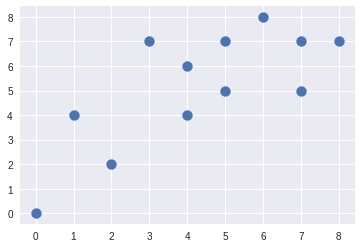

In [3]:
X = np.array([[7, 5],[5, 7],[7, 7],[4, 4],[4, 6],[1, 4],[0, 0],[2, 2],[8, 7],[6, 8],[5, 5],[3, 7]])
plt.scatter(X[:,0], X[:,1], s=100)
plt.show()

In [4]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, init="random", n_init=1, max_iter=1, random_state=1).fit(X)

[ 6.6  6.8] [ 2.71428571  4.        ]


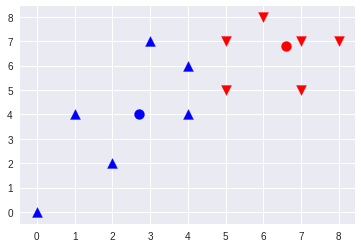

In [5]:
c0, c1 = model.cluster_centers_
print(c0, c1)
plt.scatter(X[model.labels_==0,0], X[model.labels_==0,1], s=100, marker='v', c='r')
plt.scatter(X[model.labels_==1,0], X[model.labels_==1,1], s=100, marker='^', c='b')
plt.scatter(c0[0], c0[1], s=100, c="r")
plt.scatter(c1[0], c1[1], s=100, c="b")
plt.show()

In [6]:
def kmeans_df(c0, c1):
    df = pd.DataFrame(np.hstack([X, 
                                np.linalg.norm(X - c0, axis=1)[:, np.newaxis], 
                                np.linalg.norm(X - c1, axis=1)[:, np.newaxis], 
                                model.labels_[:, np.newaxis]]),
                    columns=["x0", "x1", "d0", "d1", "c"])
    return df

kmeans_df(c0, c1)

,x0,x1,d0,d1,c
0,7.0,5.0,1.843909,4.400835,0.0
1,5.0,7.0,1.612452,3.771537,0.0
2,7.0,7.0,0.447214,5.231381,0.0
3,4.0,4.0,3.820995,1.285714,1.0
4,4.0,6.0,2.720294,2.377617,1.0
5,1.0,4.0,6.260990,1.714286,1.0
6,0.0,0.0,9.476286,4.833978,1.0
7,2.0,2.0,6.648308,2.123724,1.0
8,8.0,7.0,1.414214,6.077728,0.0
9,6.0,8.0,1.341641,5.176477,0.0


In [7]:
print(X[model.labels_==0,0].mean(), X[model.labels_==0,1].mean())
print(X[model.labels_==1,0].mean(), X[model.labels_==1,1].mean())

6.33333333333 6.5
2.33333333333 3.83333333333


In [8]:
model.score(X)

-63.004081632653012

[ 1.  2.] [ 5.44444444  6.22222222]


,x0,x1,d0,d1,c
0,7.0,5.0,6.708204,1.978277,1.0
1,5.0,7.0,6.403124,0.895806,1.0
2,7.0,7.0,7.810250,1.739164,1.0
3,4.0,4.0,3.605551,2.650413,1.0
4,4.0,6.0,5.000000,1.461438,1.0
5,1.0,4.0,2.000000,4.969040,0.0
6,0.0,0.0,2.236068,8.267891,0.0
7,2.0,2.0,1.000000,5.448978,0.0
8,8.0,7.0,8.602325,2.671292,1.0
9,6.0,8.0,7.810250,1.862562,1.0


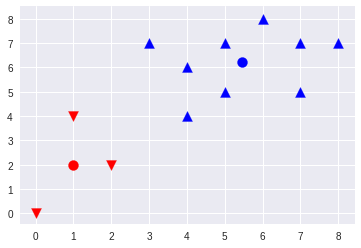

In [9]:
model = KMeans(n_clusters=2, init="random", n_init=1, max_iter=2, random_state=0).fit(X)
c0, c1 = model.cluster_centers_
print(c0, c1)
plt.scatter(X[model.labels_==0,0], X[model.labels_==0,1], s=100, marker='v', c='r')
plt.scatter(X[model.labels_==1,0], X[model.labels_==1,1], s=100, marker='^', c='b')
plt.scatter(c0[0], c0[1], s=100, c="r")
plt.scatter(c1[0], c1[1], s=100, c="b")
kmeans_df(c0, c1)

In [10]:
model.score(X)

-45.777777777777729

In [11]:
(np.linalg.norm(X[model.labels_==0] - c0, axis=1)**2).sum() + \
(np.linalg.norm(X[model.labels_==1] - c1, axis=1)**2).sum()

45.777777777777779

[ 1.  2.] [ 5.44444444  6.22222222]


,x0,x1,d0,d1,c
0,7.0,5.0,6.708204,1.978277,1.0
1,5.0,7.0,6.403124,0.895806,1.0
2,7.0,7.0,7.810250,1.739164,1.0
3,4.0,4.0,3.605551,2.650413,1.0
4,4.0,6.0,5.000000,1.461438,1.0
5,1.0,4.0,2.000000,4.969040,0.0
6,0.0,0.0,2.236068,8.267891,0.0
7,2.0,2.0,1.000000,5.448978,0.0
8,8.0,7.0,8.602325,2.671292,1.0
9,6.0,8.0,7.810250,1.862562,1.0


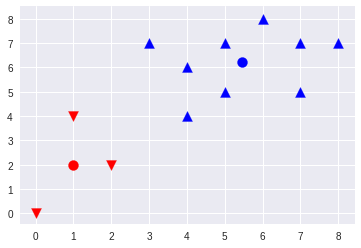

In [12]:
model = KMeans(n_clusters=2, init="random", n_init=1, max_iter=100, random_state=0).fit(X)
c0, c1 = model.cluster_centers_
print(c0, c1)
plt.scatter(X[model.labels_==0,0], X[model.labels_==0,1], s=100, marker='v', c='r')
plt.scatter(X[model.labels_==1,0], X[model.labels_==1,1], s=100, marker='^', c='b')
plt.scatter(c0[0], c0[1], s=100, c="r")
plt.scatter(c1[0], c1[1], s=100, c="b")
kmeans_df(c0, c1)

## K-Means++

K-Means++ 알고리즘은 최초의 중심값을 설정하기 위한 알고리즘이다.


1. 중심값을 저장할 집합 $M$ 준비
2. 일단 하나의 중심 $\mu_0$를 랜덤하게 선택하여 $M$에 넣는다.
3. $M$에 속하지 않는 모든 샘플 $x_i$에 대해 거리 $d(M, x_i)$를 계산. $d(M, x_i)$는 $M$안의 모든 샘플 $\mu_k$에 대해  $d(\mu_k, x_i)$를 계산하여 가장 작은 값 선택
4. $d(M, x_i)$에 비례한 확률로 다음 중심 $\mu$를 선택.
5. $K$개의 중심을 선택할 때까지 반복
6. K-Means 알고리즘 사용

### 예: Iris

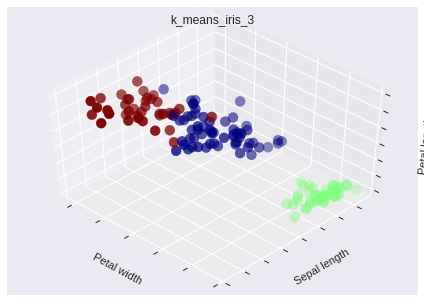

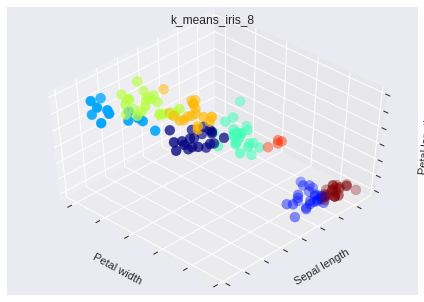

In [14]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import datasets

np.random.seed(5)
centers = [[1, 1], [-1, -1], [1, -1]]
iris = datasets.load_iris()
X = iris.data
y = iris.target

estimators = {'k_means_iris_3': KMeans(n_clusters=3),
              'k_means_iris_8': KMeans(n_clusters=8)}

fignum = 1
for name, est in estimators.items():
    fig = plt.figure(fignum)
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    plt.cla()
    est.fit(X)
    labels = est.labels_
    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(np.float), s=100, cmap=mpl.cm.jet)
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Petal width')
    ax.set_ylabel('Sepal length')
    ax.set_zlabel('Petal length')
    plt.title(name)
    fignum = fignum + 1

plt.show()

### 예: Digit Image

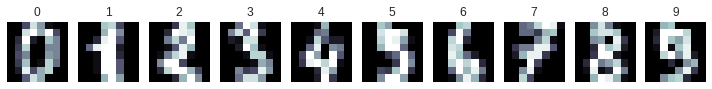

In [15]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

digits = load_digits()
data = scale(digits.data)

def print_digits(images, labels):
    f = plt.figure(figsize=(10,2))
    plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
    i = 0
    while (i < 10 and i < images.shape[0]):
        ax = f.add_subplot(1, 10, i + 1)
        ax.imshow(images[i], cmap=plt.cm.bone)
        ax.grid(False)
        ax.table
        ax.set_title(labels[i])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        plt.tight_layout()
        i += 1

print_digits(digits.images, range(10))

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, images_train, images_test = \
    train_test_split(data, digits.target, digits.images, test_size=0.25, random_state=42)

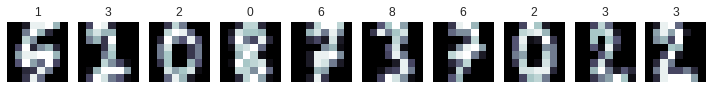

In [17]:
from sklearn.cluster import KMeans
clf = KMeans(init="k-means++", n_clusters=10, random_state=42)
clf.fit(X_train)
print_digits(images_train, clf.labels_)

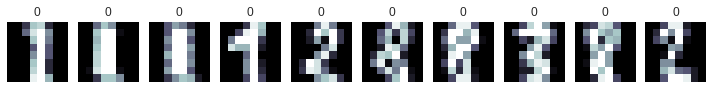

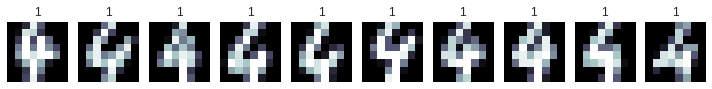

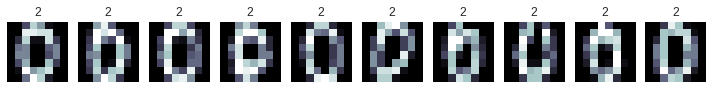

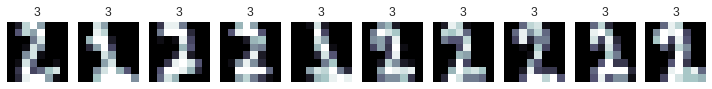

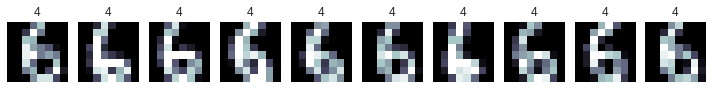

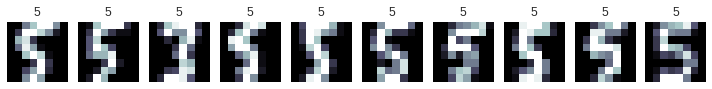

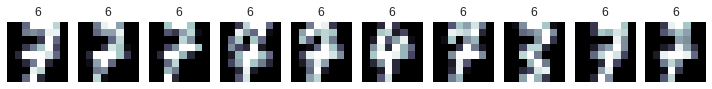

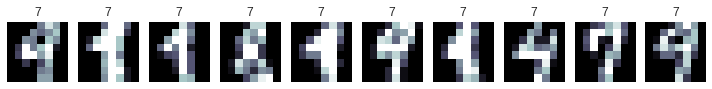

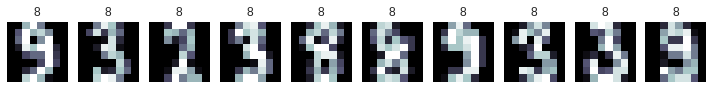

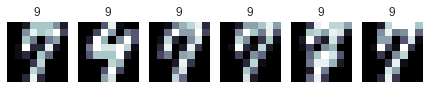

In [18]:
y_pred = clf.predict(X_test)
def print_cluster(images, y_pred, cluster_number):
    images = images[y_pred == cluster_number]
    y_pred = y_pred[y_pred == cluster_number]
    print_digits(images, y_pred)
for i in range(10):
    print_cluster(images_test, y_pred, i)

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[ 0,  0, 43,  0,  0,  0,  0,  0,  0,  0],
       [20,  0,  0,  7,  0,  0,  0, 10,  0,  0],
       [ 5,  0,  0, 31,  0,  0,  0,  1,  1,  0],
       [ 1,  0,  0,  1,  0,  1,  4,  0, 39,  0],
       [ 1, 50,  0,  0,  0,  0,  1,  2,  0,  1],
       [ 1,  0,  0,  0,  1, 41,  0,  0, 16,  0],
       [ 0,  0,  1,  0, 44,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1, 34,  1,  0,  5],
       [21,  0,  0,  0,  0,  3,  1,  2, 11,  0],
       [ 0,  0,  0,  0,  0,  2,  3,  3, 40,  0]])

## 클러스터링 성능 기준

* 정확한 답(클러스터의 갯수 및 소속)을 알고 있는 경우
    * Adjusted Rand index
    * Adjusted Mutual Information
    * Homogeneity, completeness and V-measure
    * Fowlkes-Mallows scores
    
    
    
* 정확한 답(클러스터의 갯수 및 소속)을 모르는 경우
    * Silhouette Coefficient
    * Calinski-Harabaz Index

### 예: Silhouette Coefficient

$$ s = \dfrac{b - a}{\max{(a, b)}} $$

* $a$ : 같은 클러스터에 속한 원소들의 평균 거리
* $b$ : 다른 클러스터 중 가장 가까운 클러스터까지의 평균 거리

* http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

For n_clusters = 2 The average silhouette_score is : 0.704978749608


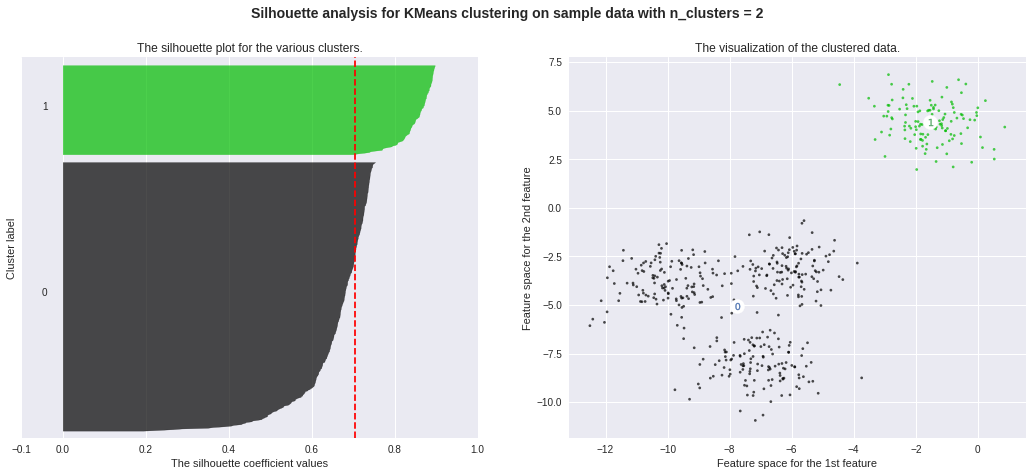

For n_clusters = 3 The average silhouette_score is : 0.588200401213


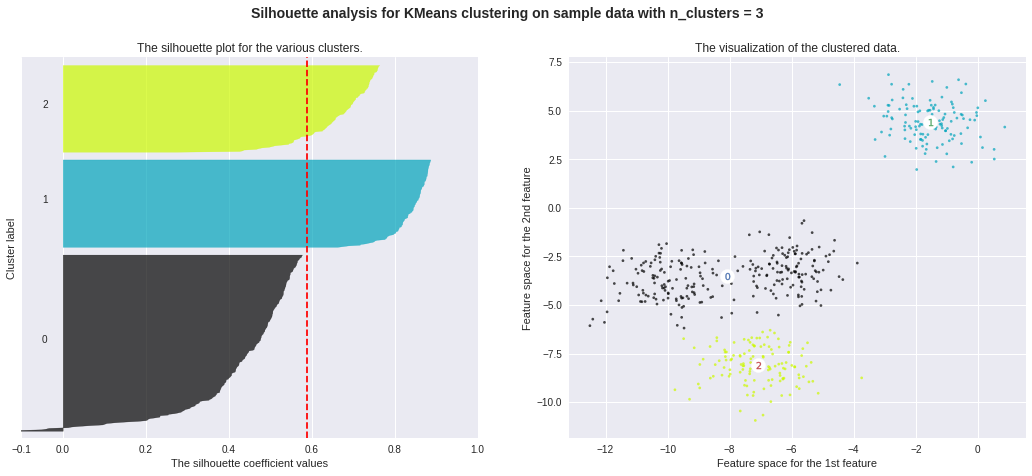

For n_clusters = 4 The average silhouette_score is : 0.650518663273


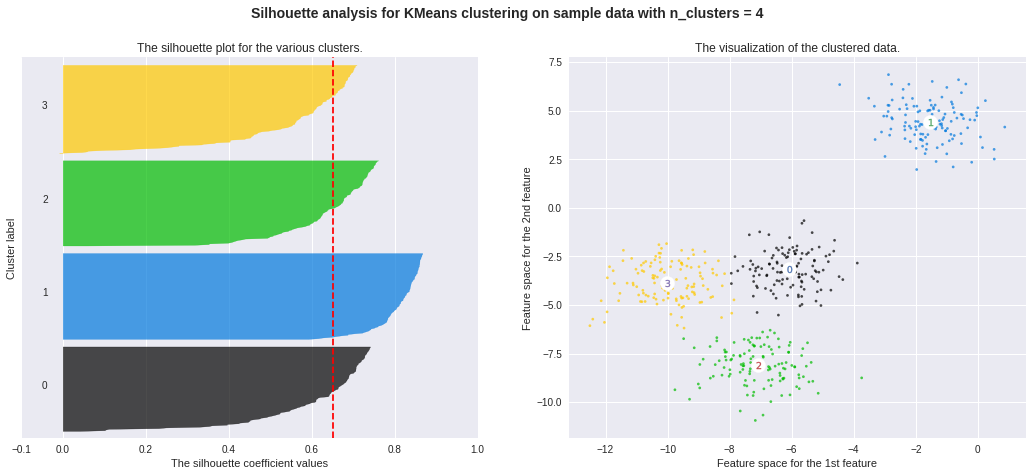

For n_clusters = 5 The average silhouette_score is : 0.563764690262


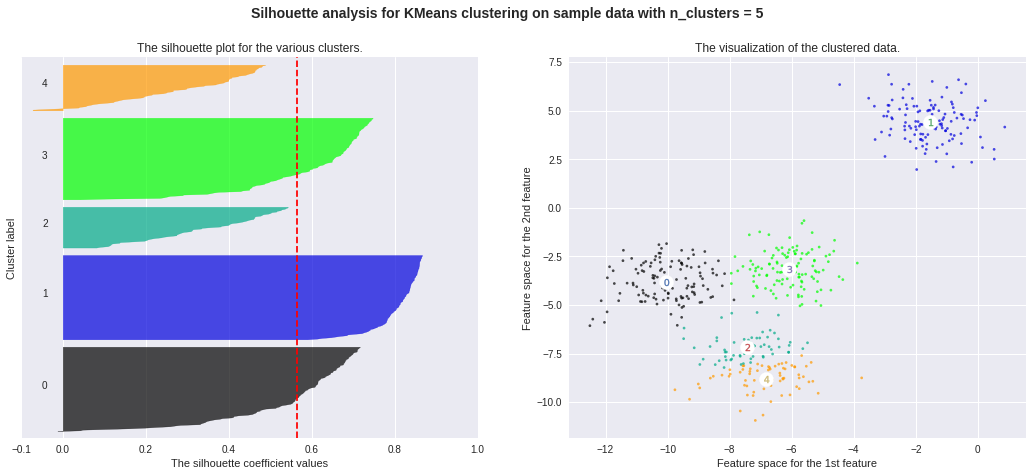

For n_clusters = 6 The average silhouette_score is : 0.450466629437


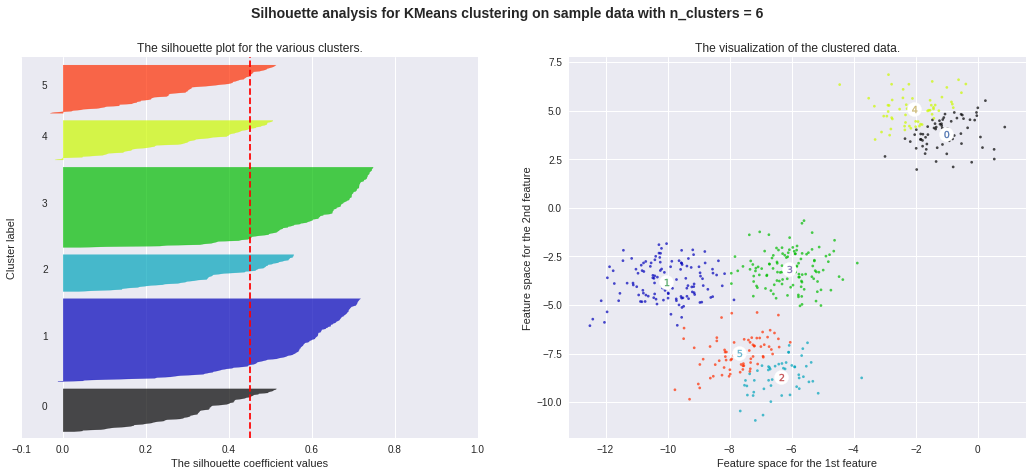

In [20]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

**Kmeans의 가장 큰 단점은 cluster의 갯수를 내가 정해줘야 한다는 것이다.**

점수가 높을수록 좋으며 붉은선을 기준으로 클러스터 전체가 붉은선에 미치지 못한다면 다른조에 속하는게 낫다는 것이며 -가 발생한 경우는 아예 다른조가 더 가깝다는 뜻이다.

K-medianss는 centroid가 반드시 data중에 존재해야한다.

# Affinity Propagation

모든 데이터가 특정한 기준에 따라 자신을 대표할 대표 데이터를 선택한다. 만약 스스로가 자기 자신을 대표하게 되면 클러스터의 중심이 된다.

* responsibility $r(i, k)$

    * $k$번째 데이터가 $i$번째 데이터의 대표가 되어야 한다는 근거


* availability $a(i, k)$

    * $i$번째 데이터가 $k$번째 데이터를 대표로 선택해야 한다는 근거
    
    
* 다음 수식을 수렴할 때까지 반복

$$ r(i, k) \leftarrow s(i, k) - \max_{k' \neq k} ( a(i, k') + s(i, k')) $$

$$ a(i, k) \leftarrow \min(0, r(k, k) + \sum_{i' \neq i,k} r(i', k)) $$

여기에서 $s(i,k)$는 다음과 같이 음의 거리로 정의되는 유사도이다.

$$ s(i,k) = -|| x_i - x_k ||^2 $$

특히 $s(k,k)$는 특정한 음수 값으로 사용자가 정해 주게 되는데 이 값에 따라서 클러스터의 갯수가 달라지는 하이퍼 모수가 된다. $s(k,k)$가 크면 자기 자신에 대한 유사도가 커져서 클러스터의 수가 증가한다.

위 알고리즘으로 계산하는 $r$, $a$가 더 이상 변화하지 않고 수렴하면 계산이 종료되고 종료 시점에서 $r(k,k) + a(k,k) > 0$이 데이터가 클러스터의 중심이 된다.

### 예 1

* http://scikit-learn.org/stable/auto_examples/cluster/plot_affinity_propagation.html

In [21]:
from sklearn.datasets.samples_generator import make_blobs

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5, random_state=0)

In [22]:
from sklearn.cluster import AffinityPropagation

model = AffinityPropagation(preference=-50).fit(X)

In [23]:
cluster_centers_indices = model.cluster_centers_indices_
labels = model.labels_
n_clusters_ = len(cluster_centers_indices)

from sklearn import metrics

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

Estimated number of clusters: 3
Homogeneity: 0.872
Completeness: 0.872
V-measure: 0.872
Adjusted Rand Index: 0.912
Adjusted Mutual Information: 0.871
Silhouette Coefficient: 0.753


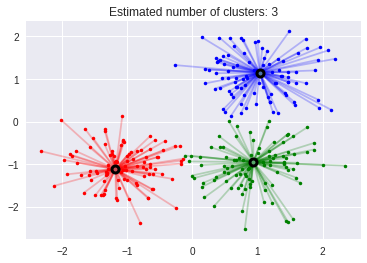

In [24]:
from itertools import cycle

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col, alpha=0.25)
    plt.plot(cluster_center[0], cluster_center[1], 'o', mec='k', mew=3, markersize=7)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### 예 2:

* http://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html

In [25]:

from datetime import datetime

from matplotlib.collections import LineCollection
from six.moves.urllib.request import urlopen
from six.moves.urllib.parse import urlencode
from sklearn import cluster, covariance, manifold


def quotes_historical_google(symbol, date1, date2):
    """Get the historical data from Google finance.

    Parameters
    ----------
    symbol : str
        Ticker symbol to query for, for example ``"DELL"``.
    date1 : datetime.datetime
        Start date.
    date2 : datetime.datetime
        End date.

    Returns
    -------
    X : array
        The columns are ``date`` -- datetime, ``open``, ``high``,
        ``low``, ``close`` and ``volume`` of type float.
    """
    params = urlencode({
        'q': symbol,
        'startdate': date1.strftime('%b %d, %Y'),
        'enddate': date2.strftime('%b %d, %Y'),
        'output': 'csv'
    })
    url = 'http://www.google.com/finance/historical?' + params
    response = urlopen(url)
    dtype = {
        'names': ['date', 'open', 'high', 'low', 'close', 'volume'],
        'formats': ['object', 'f4', 'f4', 'f4', 'f4', 'f4']
    }
    converters = {0: lambda s: datetime.strptime(s.decode(), '%d-%b-%y')}
    return np.genfromtxt(response, delimiter=',', skip_header=1,
                         dtype=dtype, converters=converters,
                         missing_values='-', filling_values=-1)


# Choose a time period reasonably calm (not too long ago so that we get
# high-tech firms, and before the 2008 crash)
d1 = datetime(2003, 1, 1)
d2 = datetime(2008, 1, 1)

symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'McDonald\'s',
    'PEP': 'Pepsi',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas Instruments',
    'XRX': 'Xerox',
    'WMT': 'Wal-Mart',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}

symbols, names = np.array(list(symbol_dict.items())).T

quotes = [
    quotes_historical_google(symbol, d1, d2) for symbol in symbols
]

close_prices = np.vstack([q['close'] for q in quotes])
open_prices = np.vstack([q['open'] for q in quotes])

# The daily variations of the quotes are what carry most information
variation = close_prices - open_prices

edge_model = covariance.GraphLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: Total, Exxon, Chevron, ConocoPhillips, Valero Energy
Cluster 2: Time Warner
Cluster 3: Cablevision
Cluster 4: Yahoo, Amazon, Apple
Cluster 5: Toyota, Canon, Sony, Honda, Unilever, Xerox, Caterpillar
Cluster 6: Navistar
Cluster 7: Northrop Grumman, General Dynamics, Raytheon
Cluster 8: Boeing
Cluster 9: Coca Cola, Pepsi, Kellogg
Cluster 10: Procter Gamble, Colgate-Palmolive, Kimberly-Clark
Cluster 11: Comcast, Ford, 3M, McDonald's, Marriott, General Electrics, Wells Fargo, JPMorgan Chase, AIG, Bank of America, Goldman Sachs, Wal-Mart, Home Depot, Pfizer, Ryder, CVS, DuPont de Nemours
Cluster 12: American express
Cluster 13: Microsoft, IBM, Dell, HP, SAP, Cisco, Texas Instruments
Cluster 14: GlaxoSmithKline, Sanofi-Aventis, Novartis


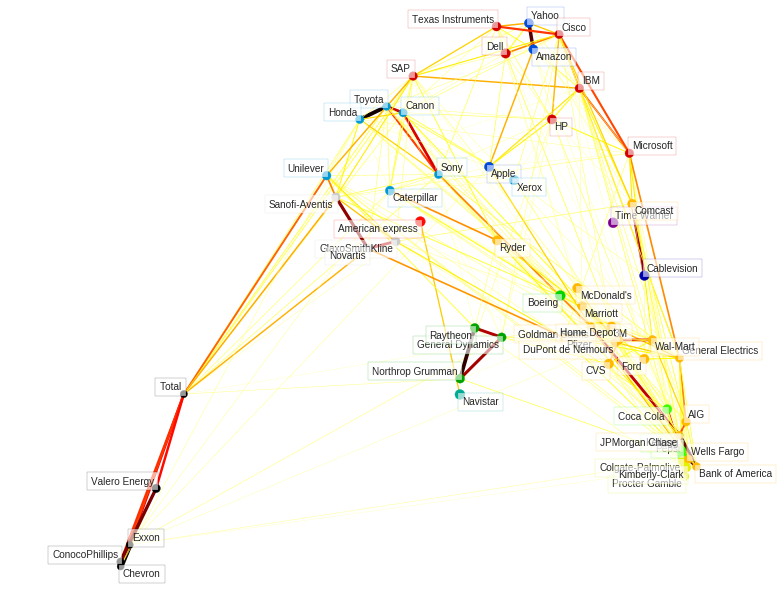

In [26]:
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()

클러스터의 수를 스스로 정한다. 유전자 분석등 대규모 데이터 분석 및 클러스터 수를 지정하기 어려울 경우에 많이 사용된다.

자기 자신의 대표자를 한명 찍는 게 AP가 하는 일이다.유용하며 현업에 적용이 가능한 수준이다.

# 계층적 클러스터링

계층적 클러스터링은 하나의 데이터 샘플을 하나의 클러스터로 보고 가장 유사도가 높은 클러스터를 합치면서 클러스터 갯수를 줄여 가는 방법을 말한다.

## 클러스터간의 유사도 측정

클러스터간의 유사도 혹은 거리를 측정하는 방법에는 다음과 같은 것이 있다.

### centroid
두 클러스터의 중심점(centroid)를 정의한 다음 두 중심점의 거리로 측정.
$$
   d(u,v) = \|c_u - c_v\|_2
$$
여기에서  $c_u$ 와 $c_v$ 는 각각 두 클러스터 $u$ 와 $v$ 의 중심점이다. 

### median
이 방법은 Agglomerative Clustering 에서 사용할 수 있는 귀납적 방법으로 centroid 방법의 변형이다.  만약 클러스터 $u$가 클러스터 $s$와 클러스터 $t$가 결합하여 생겼다면 클러스터 $u$의 중심점은 새로 계산하지 않고 원래 클러스터의 두 클러스터의 중심점의 평균을 사용한다.



데이터 간 거리 사용

---

클러스터간 거리 사용

### single
클러스터 $u$의 모든 데이터 $i$와 클러스터 $v$의 모든 데이터 $j$의 모든 조합에 대해 거리를 측정해서 최소값을 구한다. 최소 거리(Nearest Point) 방법이라고도 한다.
$$
   d(u,v) = \min(dist(u[i],v[j]))
$$

### complete
클러스터 $u$의 모든 데이터 $i$와 클러스터 $v$의 모든 데이터 $j$의 모든 조합에 대해 거리를 측정한 후 가장 큰 값을 구한다. Farthest Point
Algorithm 또는  Voor Hees Algorithm 이라고도 한다.
$$
   d(u, v) = \max(dist(u[i],v[j]))
$$

### average
클러스터 $u$의 모든 데이터 $i$와 클러스터 $v$의 모든 데이터 $j$의 모든 조합에 대해 거리를 측정한 후 평균을 구한다. $|u|$와 $|v|$는 각각 두 클러스터의 원소의 갯수를 뜻한다.
$$
   d(u,v) = \sum_{ij} \frac{d(u[i], v[j])}{(|u||v|)}
$$

### weighted

이 방법은 Agglomerative Clustering 에서 사용할 수 있는 귀납적 방법이다. 만약 클러스터 $u$가 클러스터 $s$와 클러스터 $t$가 결합하여 생겼다면 
다음과 같이 원래 클러스터까지의 두 거리의 평균을 사용한다.

$$
   d(u,v) = (dist(s,v) + dist(t,v))/2
$$

### Ward (제일 많이 쓰임)
이 방법은 Agglomerative Clustering 에서 사용할 수 있는 귀납적 방법이다. 만약 클러스터 $u$가 클러스터 $s$와 클러스터 $t$가 결합하여 생겼다면 
다음과 같이 두 클러스터의 거리의 가중 평균에서 원래의 두 클래스터 사이의 거리를 보정한 값을 사용한다.
$$
   d(u,v) = \sqrt{\frac{|v|+|s|}{|v|+|s|+|t|}d(v,s)^2 + \frac{|v|+|t|}{|v|+|s|+|t|}d(v,t)^2 - \frac{|v|}{|v|+|s|+|t|}d(s,t)^2}
$$
이 식에서 $|\cdot|$ 기호는 클러스터의 원소의 갯수를 말한다. 

weighted의 경우 클러스터간의 거리를 중심으로 설정할 때 데이터의 거리가 애매해지는데 이길이를 보정해준다. - 항에서 이를 보정한다.


## SciPy의 계층적 클러스터링 (sklearn보다 좋음)

* [scipy.cluster.hierarchy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)
 * Agglomerative 방식 클러스터링
 
 
* [scipy.cluster.hierarchy.dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html) 
 * 클러스터링 결과를 tree 형태로 시각화
 
 
* 참고 자료
 * https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Perform-the-Hierarchical-Clustering

(150, 2)


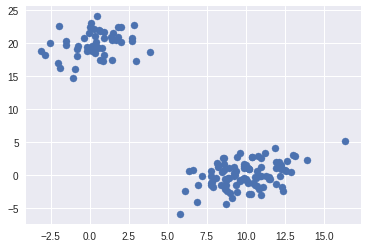

In [27]:
from scipy.cluster.hierarchy import linkage, dendrogram
np.set_printoptions(precision=5, suppress=True) 

np.random.seed(4711)  # for repeatability of this tutorial
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[100,])
b = np.random.multivariate_normal([0, 20], [[3, 1], [1, 4]], size=[50,])
X = np.concatenate((a, b),)
print(X.shape)

plt.scatter(X[:,0], X[:,1], s=50)
plt.show()

In [28]:
Z = linkage(X, 'ward')

In [29]:
Z[:20]

array([[  52.     ,   53.     ,    0.04151,    2.     ],
       [  14.     ,   79.     ,    0.05914,    2.     ],
       [  33.     ,   68.     ,    0.07107,    2.     ],
       [  17.     ,   73.     ,    0.07137,    2.     ],
       [   1.     ,    8.     ,    0.07543,    2.     ],
       [  85.     ,   95.     ,    0.10928,    2.     ],
       [ 108.     ,  131.     ,    0.11007,    2.     ],
       [   9.     ,   66.     ,    0.11302,    2.     ],
       [  15.     ,   69.     ,    0.11429,    2.     ],
       [  63.     ,   98.     ,    0.1212 ,    2.     ],
       [ 107.     ,  115.     ,    0.12167,    2.     ],
       [  65.     ,   74.     ,    0.1249 ,    2.     ],
       [  58.     ,   61.     ,    0.14028,    2.     ],
       [  62.     ,  152.     ,    0.1726 ,    3.     ],
       [  41.     ,  158.     ,    0.1779 ,    3.     ],
       [  10.     ,   83.     ,    0.18635,    2.     ],
       [ 114.     ,  139.     ,    0.20419,    2.     ],
       [  39.     ,   88.     ,

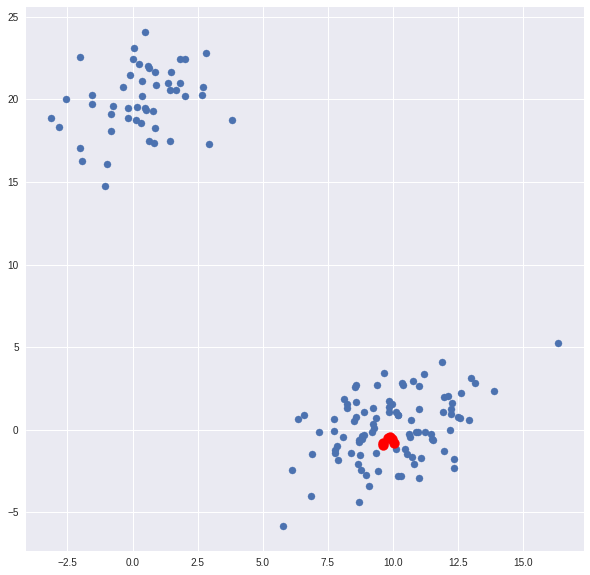

In [30]:
idxs = [33, 68, 62, 82, 63, 98]
plt.figure(figsize=(10, 10))
plt.scatter(X[:,0], X[:,1], s=50)
plt.scatter(X[idxs,0], X[idxs,1], c='r', s=100) 
plt.show()

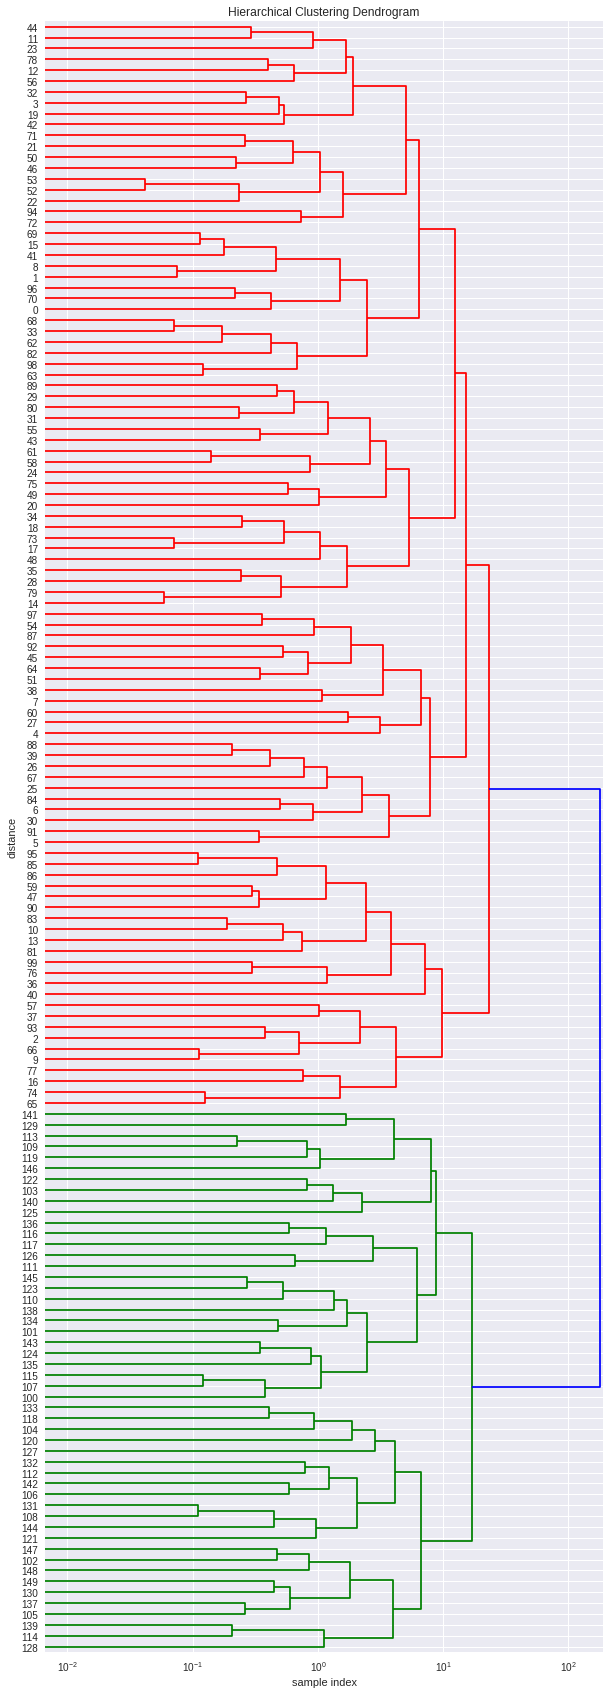

In [36]:
plt.figure(figsize=(10,30))
ax = plt.subplot(111)
dendrogram(Z, leaf_font_size=10, orientation='right')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
ax.set_xlim(xmin=1/151)
ax.set_xscale('log')
plt.show()

**데이터 수만큼의 클러스터가 있다고 가정하고 클러스터간의 거리를 구한다. (앞의 알고리즘들이 데이터와 데이터간의 similarity를 본 반면, hierarachical에서는 cluster간의 similarity를 비교한다.**

왼쪽 숫자배치가 중요하다, 1,2가 비슷하고 8,10이 비슷하고 15가 1,2와 가깝다면 순서가 1,2,15,8,10 이 순서대로 가게 된다. 즉 가까운 cluster끼리 sorting이 되어있다고 볼 수 있다.